# Udacity Data Scientist Capstone Project 
## by Dilupa Chandrasekara

## Project Overview and problem statement

Our objective is to create a machine learning algorithm that can forecast the departure of employees from a hypothetical company of moderate size, with more than 10,000 staff. The human resources department intends to use the trained model to avoid losing valuable employees on a permanent basis.


The task is to use machine learning for binary classification, predicting whether an employee is employed or has left. The primary metric for evaluation is AUROC, which is more robust than accuracy for imbalanced datasets like ours. The dataset has 14,249 current and past employees from an anonymous company, and the motivation for the project comes from investigating employee churn in the banking sector. The strategy involves exploring and cleaning the dataset before using logistic regression, random forest, and gradient-boosted trees for classification. In the second pass, the model's performance will be improved by engineering features based on bivariate segmentations. The dataset contains variables such as department, salary, tenure, recently_promoted, n_projects, avg_monthly_hrs, satisfaction, last_evaluation, and filed_complaint.

### The notebook has the following structure and contents:

Exploratory data analysis, including an exploration of the dataset, univariate and bivariate segmentation plots to generate ideas for feature engineering later on.

Data pre-processing discovery, including scratch work for data cleaning.

Modelling, involving pipeline definition, selection of four algorithms, and hyperparameter tuning, followed by model fitting.

Initial Results, consisting of cross-validation scores, confusion matrix, ROC score, and AUROC. The winning model is chosen.

Improvements to model, which involves feature engineering from bivariate segmentation and re-doing the modelling. The updated scores are checked and compared.

Final model evaluation, where the winning hyperparameters are explained, feature importance ranking is carried out, and the model is reproduced.

Data processing functions for business, including compiling data cleaning and pre-processing steps into a function for the business to use on new data, and compiling feature engineering steps into a function for the business to use on new data.

Conclusion.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set_style('darkgrid')

# ensures plots by default have a certain size and font size
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# machine learning packages
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

# miscellaneous packages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pickle

In [2]:

# read in dataset
df = pd.read_csv('employee_churn.csv')

In [3]:
df.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,221,engineering,NaN,0.932868,4,NaN,low,0.829896,Left,5.0
1,232,support,NaN,NaN,3,NaN,low,0.834544,Employed,2.0
2,184,sales,NaN,0.788830,3,NaN,medium,0.834988,Employed,3.0
3,206,sales,NaN,0.575688,4,NaN,low,0.424764,Employed,2.0
4,249,sales,NaN,0.845217,3,NaN,low,0.779043,Employed,3.0


In [4]:
df.shape


(14249, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14249 entries, 0 to 14248
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_monthly_hrs    14249 non-null  int64  
 1   department         13540 non-null  object 
 2   filed_complaint    2058 non-null   float64
 3   last_evaluation    12717 non-null  float64
 4   n_projects         14249 non-null  int64  
 5   recently_promoted  300 non-null    float64
 6   salary             14249 non-null  object 
 7   satisfaction       14068 non-null  float64
 8   status             14249 non-null  object 
 9   tenure             14068 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 1.1+ MB


In [6]:
df.describe()


,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure
count,14249.000000,2058.0,12717.000000,14249.000000,300.0,14068.000000,14068.000000
mean,199.795775,1.0,0.718477,3.773809,1.0,0.621295,3.497228
std,50.998714,0.0,0.173062,1.253126,0.0,0.250469,1.460917
min,49.000000,1.0,0.316175,1.000000,1.0,0.040058,2.000000
25%,155.000000,1.0,0.563866,3.000000,1.0,0.450390,3.000000
50%,199.000000,1.0,0.724939,4.000000,1.0,0.652527,3.000000
75%,245.000000,1.0,0.871358,5.000000,1.0,0.824951,4.000000
max,310.000000,1.0,1.000000,7.000000,1.0,1.000000,10.000000


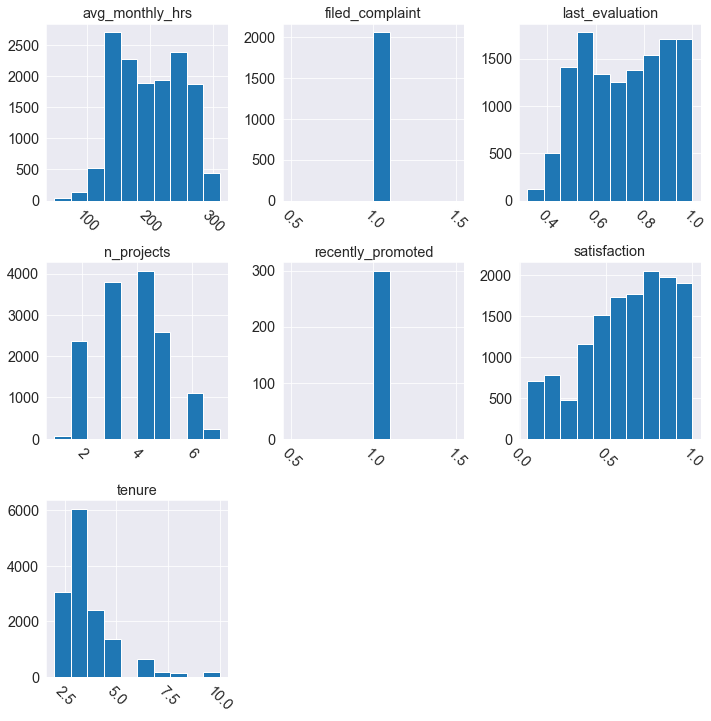

In [7]:
# plot distribution of numerical features
df.hist(figsize=(10,10), xrot=-45)
plt.tight_layout()
plt.savefig('Notebook Diagrams/diagram_hist.png', bbox_inches='tight', format='png')
plt.show()


In [8]:
df.dtypes

avg_monthly_hrs        int64
department            object
filed_complaint      float64
last_evaluation      float64
n_projects             int64
recently_promoted    float64
salary                object
satisfaction         float64
status                object
tenure               float64
dtype: object

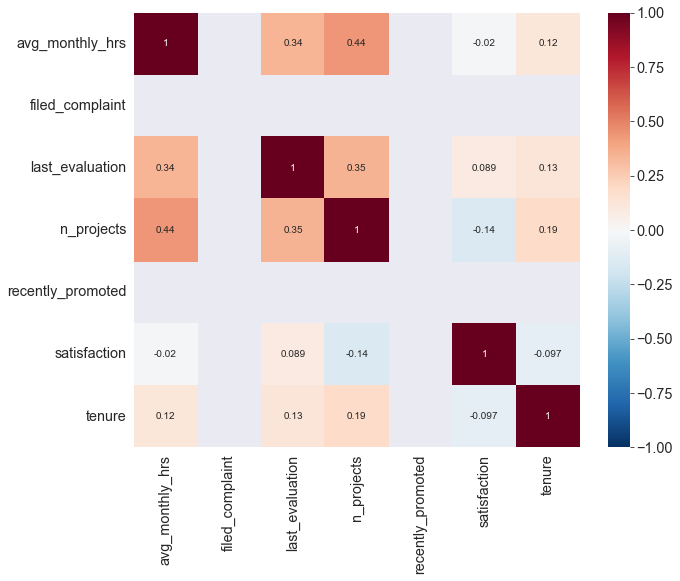

In [9]:
# print correlation heatmap
corr = df.corr()
plt.figure(figsize=(10,8))
sb.heatmap(corr,
          annot=True,
          cmap='RdBu_r',
          vmin=-1,
          vmax=1)
plt.show()

In the exploratory data analysis, it is noted that there are some NaN values in filed_complaint and recently_promoted, which will be fixed later. The heatmap analysis is temporarily incomplete, but it will be reproduced later. The analysis shows that the strongest correlation is between n_projects and avg_monthly_hours, which is not surprising, as both features can be considered as proxies for workload.

### Categorical features info

In [10]:
df.describe(include=['object'])

,department,salary,status
count,13540,14249,14249
unique,12,3,2
top,sales,low,Employed
freq,3923,6952,10857


In the dataset, there are 12 departments, 3 salary classes, and 2 classes for the target variable. However, it should be noted that both department and salary contain missing values.

### Bar charts for the categorical variables


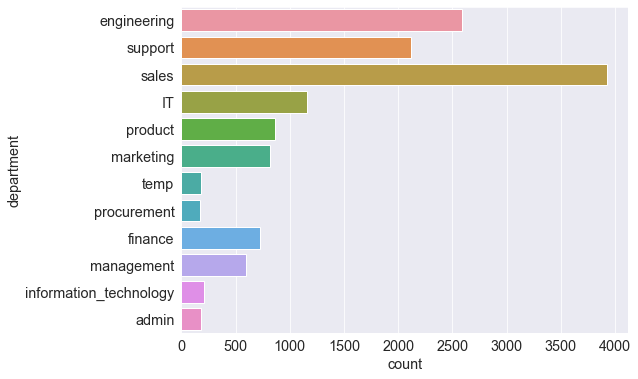

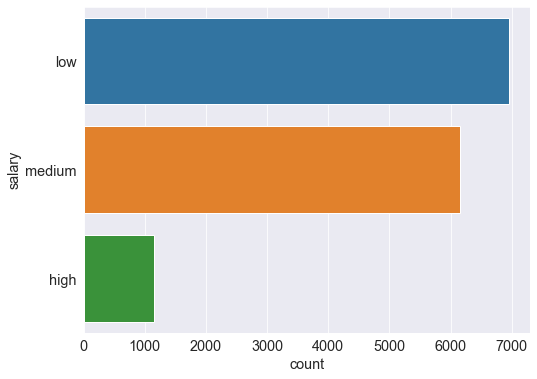

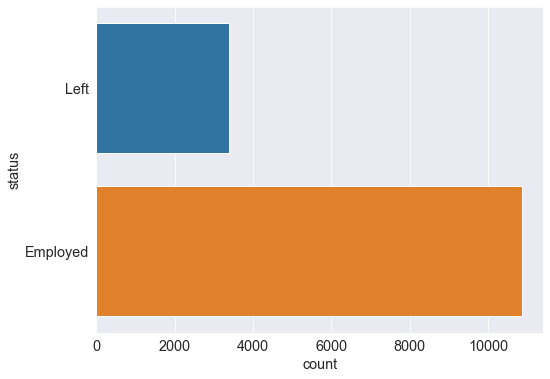

In [11]:
for feature in df.dtypes[df.dtypes=='object'].index:
    sb.countplot(y=feature, data=df)
    plt.savefig('Notebook Diagrams/diagram_countplot_{}.png'.format(feature), bbox_inches='tight', format='png')
    plt.show()

In the analysis, it is noted that there are no sparse classes in the dataset. However, there are some employees who are not permanent employees, but rather "temps," and they are out of scope for this project. Therefore, they should be removed from the analytical base table. Additionally, there are two similar classes, Information Technology and IT, which should be merged into a single class.

## The next step in the analysis involves determining the workload for different departments by grouping the data by department and performing some aggregate calculations.

In [12]:
df.groupby('department').mean().sort_values(by='avg_monthly_hrs', ascending=False)


,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure
department,,,,,,,
engineering,202.469522,1.0,0.722332,3.872299,1.0,0.617907,3.402392
IT,202.175711,1.0,0.720712,3.806202,1.0,0.628324,3.481481
information_technology,202.167464,1.0,0.716156,3.832536,1.0,0.626717,3.315789
admin,201.272727,1.0,0.726282,3.897727,1.0,0.611450,3.369318
finance,201.175824,1.0,0.723880,3.815934,1.0,0.586787,3.543956
management,201.025210,1.0,0.729714,3.857143,1.0,0.630428,4.294118
support,200.975495,1.0,0.723200,3.804430,1.0,0.626923,3.394910
sales,200.842467,1.0,0.711254,3.772878,1.0,0.623075,3.527148
product,199.991860,1.0,0.719616,3.817442,NaN,0.628774,3.487209


As you can Engineering and IT has the highest workload

## The analysis will now focus on studying the target variable, "status," in more detail. The features in the dataset generally provide information about an employee's happiness, performance, workload, and experience. First, univariate segmentations will be performed on some of these features before combining them in bivariate pairs to generate ideas for feature engineering. The first univariate segmentation will be of satisfaction (i.e., happiness) by status, with the hypothesis being that less satisfied employees may be more likely to leave their job.

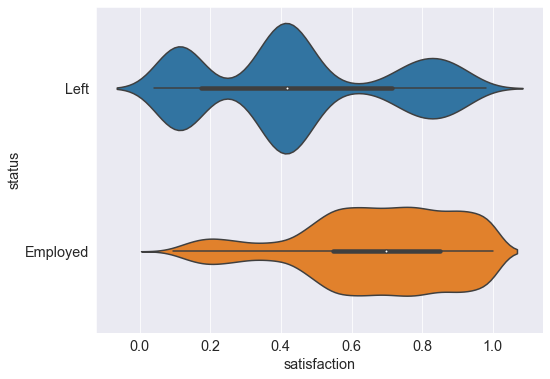

In [13]:
sb.violinplot(y='status', x='satisfaction', data=df)
plt.savefig('Notebook Diagrams/diagram_univariate_satisfaction.png', bbox_inches='tight', format='png')
plt.show()

According to the analysis, the currently employed employees are generally satisfied with their jobs, which is not surprising. However, the employees who have left their jobs also include highly satisfied employees, which is something that will be revisited later in the analysis.

## The next step is to perform a univariate segmentation of last_evaluation (i.e. performance) by status. The hypothesis is that low performance may be correlated with leaving.

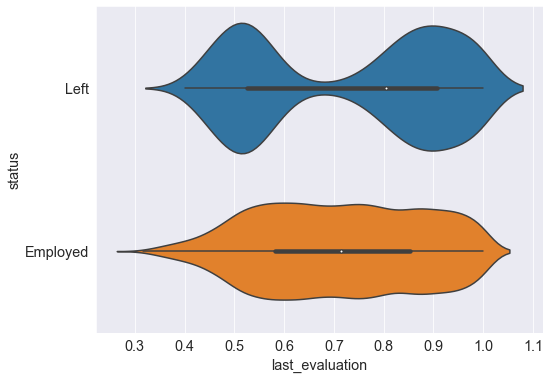

In [14]:
sb.violinplot(y='status', x='last_evaluation', data=df)
plt.savefig('Notebook Diagrams/diagram_univariate_last_evaluation.png', bbox_inches='tight', format='png')
plt.show()

The comment on the result of the univariate segmentation of last_evaluation by status is that those who left the company had either very low or very high performance. This might indicate that overachievers or those who felt they had no room to grow in the company were more likely to leave.

## Now let's check the status with the avg_monthly_hrs to check whether overworking makes employees leave more

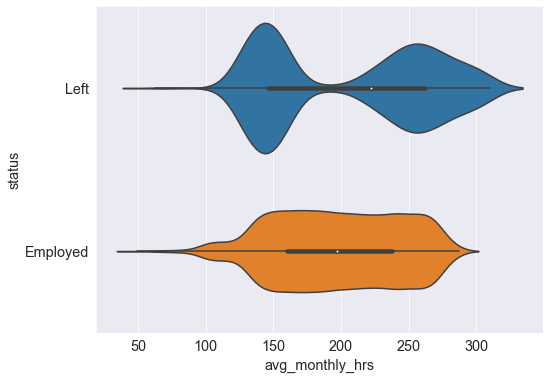

In [15]:
sb.violinplot(y='status', x='avg_monthly_hrs', data=df)
plt.savefig('Notebook Diagrams/diagram_univariate_avg_monthly_hrs.png', bbox_inches='tight', format='png')
plt.show()

Intersting fact here is that employees who had left either have low working hours or high working hours. There's not many employees in that in-between range. 

## Now let's check the same thing with the number of projects employees have been working on. Because number of projects comes into consideration when it comes to workload.

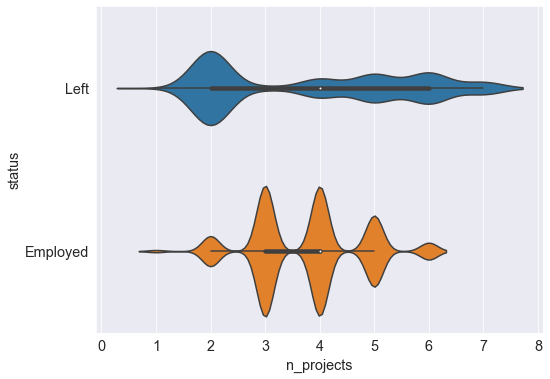

In [16]:

sb.violinplot(y='status', x='n_projects', data=df)
plt.savefig('Notebook Diagrams/diagram_univariate_n_projects.png', bbox_inches='tight', format='png')
plt.show()

This is a repetition of a previous comment about the relationship between workload and employee churn. The comment suggests that it is noteworthy that a large number of employees with low workloads left, potentially indicating employee disengagement as a contributing factor to churn. And there are more employees who have left done more projects than ususal.

## Now let's check the tenure with the status

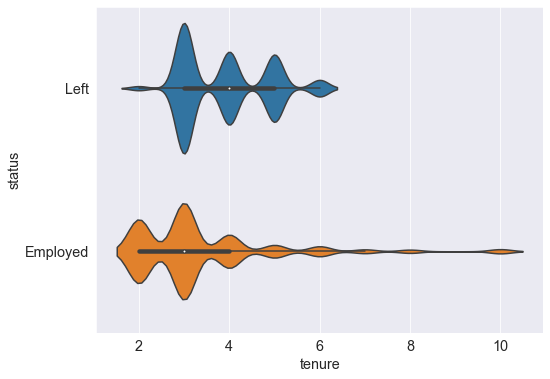

In [17]:
sb.violinplot(y='status', x='tenure', data=df)
plt.savefig('Notebook Diagrams/diagram_univariate_tenure.png', bbox_inches='tight', format='png')
plt.show()

As you can see the employees who left have stayed with the company for a longer period

## Bivariate segmentation of employee satisfaction and last evaluation(performance) is done with the status to investigate further

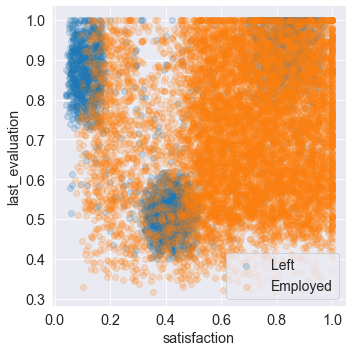

In [18]:
sb.lmplot(x='satisfaction',
          y='last_evaluation',
          hue='status',
          data=df,
          fit_reg=False,
          legend=False,
          scatter_kws={'alpha' : 0.2},
         )

plt.legend(loc='lower right', fontsize=14)
plt.savefig('Notebook Diagrams/diagram_bivariate_last_evaluation_satisfaction_1.png', bbox_inches='tight', format='png')
plt.show()

The graph is not very clear so we will narrow it down to employees who have left

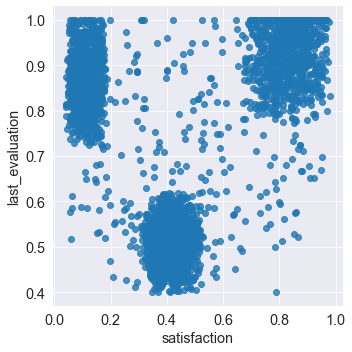

In [19]:
sb.lmplot(x='satisfaction',
          y='last_evaluation',
          data=df[df.status=='Left'],
          fit_reg=False,
          legend=False
         )

plt.savefig('Notebook Diagrams/diagram_bivariate_last_evaluation_satisfaction_2.png', bbox_inches='tight', format='png')
plt.show()

As you can see 3 main clusters are present. We can categorize them as underperformers, unhappy and overacheivers. We will be using this for feature engineering

## We can conduct a bivariate segmentation analysis of the variables last_evaluation (employee performance) and avg_monthly_hrs (workload) with a focus on the group of employees who have left the company. This analysis will involve examining how these two variables relate to each other for employees who have left, with the goal of identifying any patterns or subgroups that may exist within this population.

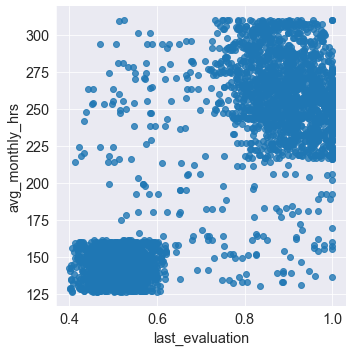

In [20]:
sb.lmplot(x='last_evaluation',
         y='avg_monthly_hrs',
         data=df[df.status=='Left'],
         fit_reg=False)

plt.savefig('Notebook Diagrams/diagram_bivariate_avg_monthly_hrs_last_evaluation.png', bbox_inches='tight', format='png')
plt.show()

Two distinctive clusters are present here as well. Employees who have worked hard and employees who have slacked off. This will be used for feature engineering as well

## Let's do the same thing replacing performance(last_evaluation) with satisfaction

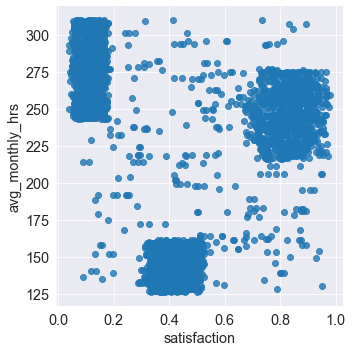

In [21]:
sb.lmplot(x='satisfaction',
          y='avg_monthly_hrs',
          data=df[df.status=='Left'],
          fit_reg=False,
         )

plt.savefig('Notebook Diagrams/diagram_bivariate_avg_monthly_hrs_satisfaction.png', bbox_inches='tight', format='png')
plt.show()

Three distinctive clusters with having high performers with low satisfaction , medium performers with medium satisfaction and high performers with high satisfaction 

# 2. Data Pre-Processing

## Dropping duplicates


In [22]:
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(14249, 10)
(14221, 10)


## Checking for null values

In [23]:
df.isnull().sum()

avg_monthly_hrs          0
department             709
filed_complaint      12165
last_evaluation       1504
n_projects               0
recently_promoted    13921
salary                   0
satisfaction           153
status                   0
tenure                 153
dtype: int64

Tenure, satisfaction, recently_promoted, last_evaluation, filled_complaint and department have missing values

filled_complaint and recently promoted have binary values. Missing values NaN mean it's 0. Let's apply that change

In [24]:
df.filed_complaint.unique()


array([nan,  1.])

In [25]:
df.filed_complaint.fillna(0, inplace=True)

In [26]:
df.filed_complaint.unique()

array([0., 1.])

In [27]:
df.recently_promoted.fillna(0, inplace=True)

In [28]:
df.recently_promoted.unique()

array([0., 1.])

In [29]:
df.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,221,engineering,0.0,0.932868,4,0.0,low,0.829896,Left,5.0
1,232,support,0.0,NaN,3,0.0,low,0.834544,Employed,2.0
2,184,sales,0.0,0.788830,3,0.0,medium,0.834988,Employed,3.0
3,206,sales,0.0,0.575688,4,0.0,low,0.424764,Employed,2.0
4,249,sales,0.0,0.845217,3,0.0,low,0.779043,Employed,3.0


In [30]:
df.isnull().sum()

avg_monthly_hrs         0
department            709
filed_complaint         0
last_evaluation      1504
n_projects              0
recently_promoted       0
salary                  0
satisfaction          153
status                  0
tenure                153
dtype: int64

Now moving into Salary column, it consists with ordinal data ranging from Low to High. Let's encode them with numerical values for future algorithms that we are going to use

In [31]:
df['salary_numeric'] = df.salary.replace({'low':0, 'medium':1, 'high':2})

In [32]:

df.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,salary_numeric
0,221,engineering,0.0,0.932868,4,0.0,low,0.829896,Left,5.0,0
1,232,support,0.0,NaN,3,0.0,low,0.834544,Employed,2.0,0
2,184,sales,0.0,0.788830,3,0.0,medium,0.834988,Employed,3.0,1
3,206,sales,0.0,0.575688,4,0.0,low,0.424764,Employed,2.0,0
4,249,sales,0.0,0.845217,3,0.0,low,0.779043,Employed,3.0,0


## Correlation heatmap with the numerical values


In [33]:
corr = df.corr()

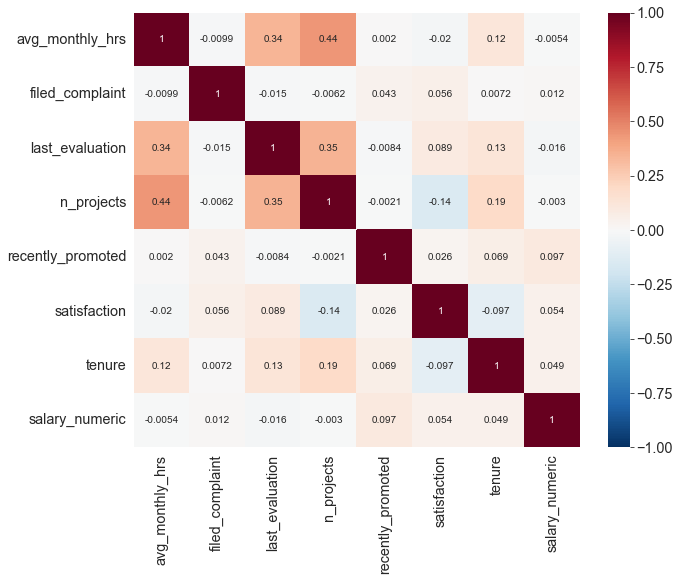

In [34]:
plt.figure(figsize=(10,8))
sb.heatmap(corr,
          annot=True,
          cmap='RdBu_r',
          vmin=-1,
          vmax=1)

plt.savefig('Notebook Diagrams/diagram_corr.png', bbox_inches='tight', format='png')
plt.show()

Next data cleaning step is combining IT and information technology classes in department

In [35]:
df.department.replace('information_technology', 'IT', inplace=True)

Removing the temp classes because we are not considering them for this study

In [36]:
df = df[df.department != 'temp']

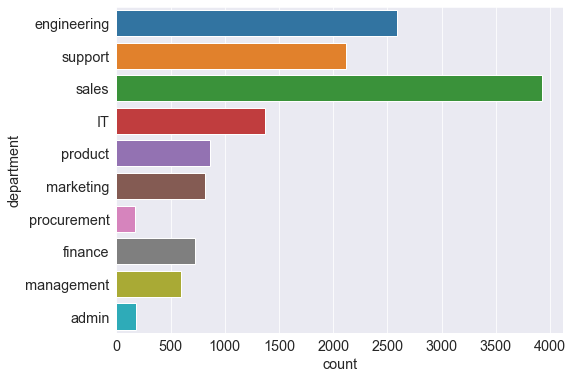

In [37]:
sb.countplot(y='department', data=df)
plt.savefig('Notebook Diagrams/diagram_countplot_department_2.png', bbox_inches='tight', format='png')
plt.show()

In [38]:
## Rechecking for null values
df.isnull().sum()

avg_monthly_hrs         0
department            709
filed_complaint         0
last_evaluation      1351
n_projects              0
recently_promoted       0
salary                  0
satisfaction            0
status                  0
tenure                  0
salary_numeric          0
dtype: int64

Now department and last evaluation has null values. Removing temp has caused Tenure and satisfaction missing values to dissapear. That means those null values must have been belong to Temp workers

Let's fill the null values of Department now

In [39]:
df['department'].fillna('Missing', inplace=True)

In [40]:
df.department.value_counts()

sales          3923
engineering    2592
support        2122
IT             1370
product         860
marketing       819
finance         728
Missing         709
management      595
admin           176
procurement     174
Name: department, dtype: int64

In [41]:
df.isnull().sum()

avg_monthly_hrs         0
department              0
filed_complaint         0
last_evaluation      1351
n_projects              0
recently_promoted       0
salary                  0
satisfaction            0
status                  0
tenure                  0
salary_numeric          0
dtype: int64

Now for last_evaluation we will replace the NaN values with 0 but before doing that we will have an another column to indicate the missing values of the last_evaluation column.

In [42]:
df['last_evaluation_missing'] = df.last_evaluation.isnull().astype(int)

In [43]:
df.last_evaluation.fillna(0, inplace=True)

In [44]:
df.isnull().sum()

avg_monthly_hrs            0
department                 0
filed_complaint            0
last_evaluation            0
n_projects                 0
recently_promoted          0
salary                     0
satisfaction               0
status                     0
tenure                     0
salary_numeric             0
last_evaluation_missing    0
dtype: int64

For future purposes we will convert the status into a dummy variable.

In [45]:
df['status'] = pd.get_dummies(df.status).Left

In [46]:

df.status.mean()

0.23933750355416547

In [47]:
## Creating dummy variable for other two categorical variables
df = pd.get_dummies(df, columns=['department', 'salary'])

In [48]:
df.head(10)

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,status,tenure,salary_numeric,last_evaluation_missing,department_IT,department_Missing,department_admin,department_engineering,department_finance,department_management,department_marketing,department_procurement,department_product,department_sales,department_support,salary_high,salary_low,salary_medium
0,221,0.0,0.932868,4,0.0,0.829896,1,5.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,232,0.0,0.000000,3,0.0,0.834544,0,2.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,184,0.0,0.788830,3,0.0,0.834988,0,3.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,206,0.0,0.575688,4,0.0,0.424764,0,2.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,249,0.0,0.845217,3,0.0,0.779043,0,3.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
5,140,0.0,0.589097,4,0.0,0.660020,0,4.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
6,121,1.0,0.625399,3,0.0,0.835571,0,3.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
7,150,0.0,0.644586,4,0.0,0.796683,0,3.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
8,215,1.0,0.524114,3,0.0,0.715005,0,7.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
9,269,0.0,0.909364,5,0.0,0.994037,0,2.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [49]:
## Saving the table for modelling

df.to_csv('Modelling table 1.csv', index=None)

Above table will be used for doing the analysis and modelling.

At this point, we have not yet created the 8 features that we identified through our bivariate segmentations. Instead, we want to evaluate the performance of our model using the existing features first. In the next section, we will build an improved version of the model that includes these new features to see if they improve performance. Additionally, we plan to create a function in Section 7 that will automate the preprocessing steps we have taken so that businesses can use it on new data.

# Modelling


In [50]:
## Reading the analytical table
df = pd.read_csv('modelling table 1.csv')

In [51]:
y = df.status
X = df.drop('status', axis=1)

In [52]:
# Split into train and test using stratified sampling to ensure the target variable's classes are balanced:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=df.status)

In [53]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

11254 2814 11254 2814


In [54]:
## Creating pipeline dictionary for four algorithms: L1-regularised & L2-regularised logistic regression, random forest, gradient boosted tree:
pipelines = {
    'l1': make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', random_state=123)),
    'l2': make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=123)),
    'rf': make_pipeline(RandomForestClassifier(random_state=123)),
    'gb': make_pipeline(GradientBoostingClassifier(random_state=123))
}

We need to specify hyperparameter grids and create a dictionary for hyperparameters. The strength of the penalty, C, is the most important hyperparameter for logistic regression, as it can have a significant impact on the model's performance.

In [55]:
hyperparameters = {
    "l1": {
        "logisticregression__penalty": ["l1"],
        "logisticregression__C": [0.01, 0.1, 1, 10, 100],
        "logisticregression__solver": ["liblinear"]
    },
    "l2": {
        "logisticregression__penalty": ["l2"],
        "logisticregression__C": [0.01, 0.1, 1, 10, 100]
    },
    "rf": {
        "randomforestclassifier__n_estimators": [10, 50, 100],
        "randomforestclassifier__max_features": ['sqrt', 'log2'],
        "randomforestclassifier__min_samples_leaf": [1, 3, 5]
    },
    "gb": {
        "gradientboostingclassifier__n_estimators": [10, 50, 100],
        "gradientboostingclassifier__learning_rate": [0.01, 0.1, 1],
        "gradientboostingclassifier__max_depth": [3, 5, 7]
    }
}

To optimize our random forest model, we will need to adjust several hyperparameters. These include the number of estimators, the maximum number of features to consider when splitting a node, and the minimum number of samples required to form a leaf node in the tree.

For Gradient boosted tree we will tune the number of estimators, the learning rate and maximum number of a tree.

In [56]:
## Fit and tune models with cross-validation
fitted_models = {}

# loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    
    print("Currently fitting:", name)
    
    # create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # fit model and store it in fitted_models disctionary
    model.fit(X_train, y_train)
    fitted_models[name] = model
    
    print("Fitting for", name, "completed.")

Currently fitting: l1
Fitting for l1 completed.
Currently fitting: l2
Fitting for l2 completed.
Currently fitting: rf
Fitting for rf completed.
Currently fitting: gb
Fitting for gb completed.


# 4. Initial Results



In [57]:
for name, model in fitted_models.items():
    print(name, model.best_score_)

l1 0.7808764160252615
l2 0.7808764160252615
rf 0.9781402802447208
gb 0.9772526544306295


Results for: l1 

[[1997  144]
 [ 430  243]]

AUROC: 0.8461155686091889


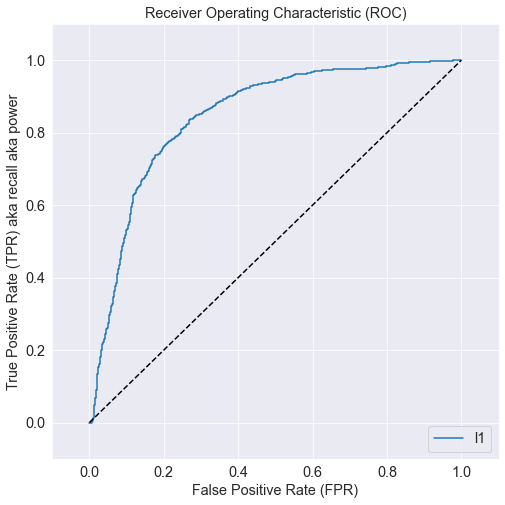



Results for: l2 

[[1998  143]
 [ 428  245]]

AUROC: 0.8460989122717648


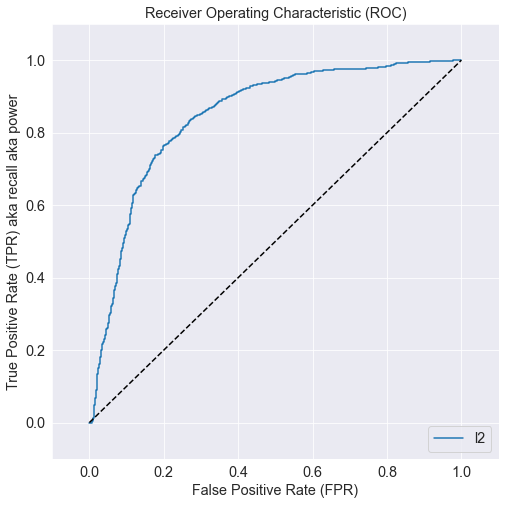



Results for: rf 

[[2128   13]
 [  50  623]]

AUROC: 0.9916839765339966


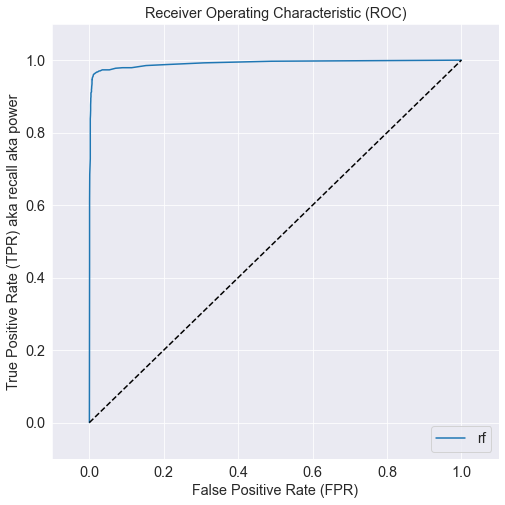



Results for: gb 

[[2123   18]
 [  44  629]]

AUROC: 0.9887621773441887


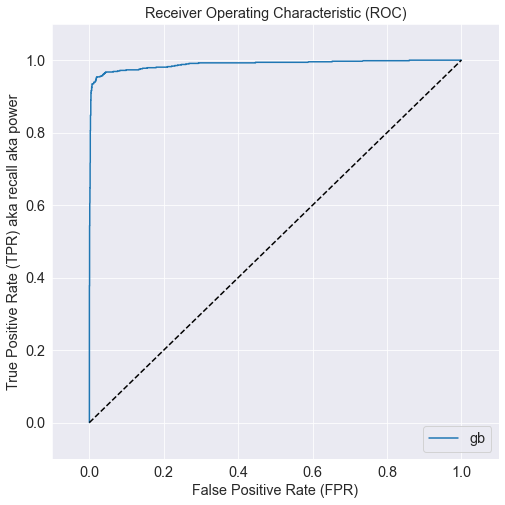

In [58]:
## Now, for each algorithm, obtain confusion matrix and display ROC curve and print AUROC scores:
for name, model in fitted_models.items():
    print("Results for:", name, "\n")
    
    # get predictions and print confusion matrix
    pred = fitted_models[name].predict(X_test)
    print(confusion_matrix(y_test, pred))
    
    # get probabilities of predictions (positive class only) and display ROC curve
    pred = fitted_models[name].predict_proba(X_test)
    pred = [p[1] for p in pred]
    
    # print AUROC score
    print("\nAUROC:", roc_auc_score(y_test, pred))
    
    fpr, tpr, thresholds = roc_curve(y_test, pred) # obtain False Positive Rates, True Positive Rates and thresholds
    fig = plt.figure(figsize=(8,8))
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.plot(fpr, tpr, label=name) # ROC curve
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'k--') # diagonal line
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.ylabel('True Positive Rate (TPR) aka recall aka power')
    plt.xlabel('False Positive Rate (FPR)')
    plt.show()
    
    print("\n")

With AUROC values around 99 random forest and gradient boosted tree performed exceptionally.
Logistic regression models scored approximately close to 85 which was not too bad but random forest was the best fit

In [59]:
## Saving the final model as .pkl file
with open('model_v1.pkl', 'wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)


# 5. With the help of feature engineering we will try to improve the model now

As the first step, take a look at the old table that we used for the above models

In [60]:
df = pd.read_csv('Modelling table 1.csv')

In [61]:

df.head()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,status,tenure,salary_numeric,last_evaluation_missing,department_IT,department_Missing,department_admin,department_engineering,department_finance,department_management,department_marketing,department_procurement,department_product,department_sales,department_support,salary_high,salary_low,salary_medium
0,221,0.0,0.932868,4,0.0,0.829896,1,5.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,232,0.0,0.000000,3,0.0,0.834544,0,2.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,184,0.0,0.788830,3,0.0,0.834988,0,3.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,206,0.0,0.575688,4,0.0,0.424764,0,2.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,249,0.0,0.845217,3,0.0,0.779043,0,3.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


From the performance and happiness segmentation that we did earlier we derive the following plot

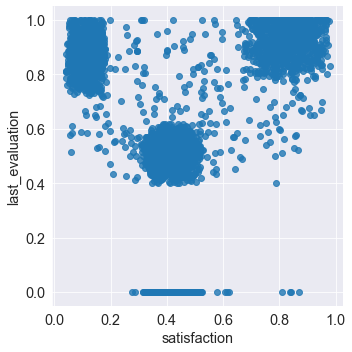

In [62]:
sb.lmplot(x='satisfaction',
         y='last_evaluation',
         data=df[df.status==1],
         fit_reg=False)
plt.show()

The data cleaning steps resulted in some 0 values for the 'last_evaluation' feature, which were excluded from the modeling using the condition 'df.last_evaluation_missing==0'. New features were defined based on the following logic:

'Underperformers': employees with 'last_evaluation' score less than 0.6
'Unhappy': employees with 'satisfaction_level' score less than 0.2, which could indicate overqualified and bored employees
'Overachievers': employees with both 'last_evaluation' score greater than 0.8 and 'satisfaction_level' score greater than 0.7.

In [63]:
df['underperformer'] = ((df.last_evaluation < 0.6) & (df.last_evaluation_missing==0)).astype(int)
df['unhappy'] = (df.satisfaction < 0.2).astype(int)
df['overachiever'] = ((df.last_evaluation > 0.8) & (df.satisfaction > 0.7)).astype(int)

## Analysis from the performance and workload segmentation

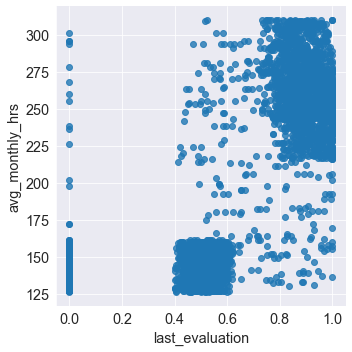

In [64]:
sb.lmplot(x='last_evaluation',
         y='avg_monthly_hrs',
         data=df[df.status==1],
         fit_reg=False)
plt.show()

it seems that there was a data cleaning process conducted and a subset of data with last_evaluation equals to zero was removed from the dataset before modelling. Additionally, two new features were defined using specific criteria:

The "Stars" feature is created for employees whose average monthly hours are greater than 215 and whose last evaluation score is higher than 0.75.

The "Slackers" feature is created for employees whose average monthly hours are less than 165 and whose last evaluation score is lower than 0.65.

These new features can be useful in identifying high-performing and low-performing employees, respectively, and can potentially improve the accuracy of the model.

In [65]:
df['stars'] = ((df.avg_monthly_hrs > 215) & (df.last_evaluation > 0.75)).astype(int)
df['slackers'] = ((df.avg_monthly_hrs < 165) & (df.last_evaluation < 0.65) & (df.last_evaluation_missing==0)).astype(int)
 

## Last analysis on happines and workload

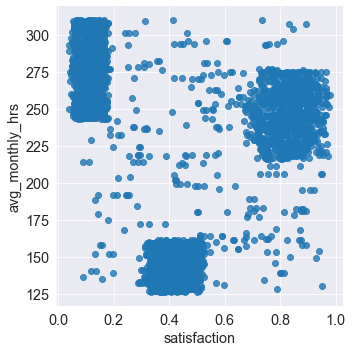

In [66]:
sb.lmplot(x='satisfaction',
          y='avg_monthly_hrs',
          data=df[df.status==1],
          fit_reg=False,
         )
plt.show()


According to the given statement, three new features are defined based on specific criteria as follows:

The "Workaholics" feature is created for employees whose average monthly hours are greater than 210 and whose satisfaction score is higher than 0.7.

The "Just-a-job" feature is created for employees whose average monthly hours are less than 170, regardless of their satisfaction score.

The "Overworked" feature is created for employees whose average monthly hours are greater than 225 and whose satisfaction score is lower than 0.2.

These new features can potentially provide additional insights into the characteristics and performance of employees in the dataset, which could be useful for modeling and analysis purposes. However, it's important to note that these features were defined based on specific criteria and may not necessarily capture all relevant factors that contribute to employee performance or satisfaction. Therefore, further analysis and evaluation may be required to determine the effectiveness of these features in the model.

In [67]:
df['workaholic'] = ((df.avg_monthly_hrs > 210) & (df.satisfaction > 0.7)).astype(int)
df['justajob'] = (df.avg_monthly_hrs < 170).astype(int)
df['overworked'] = ((df.avg_monthly_hrs > 225) & (df.satisfaction < 0.2)).astype(int)

Amount of employees that belong to each group that we discussed, will be as follows

In [68]:
df[['underperformer', 'unhappy', 'overachiever', 'stars', 'slackers', 'underperformer', 'unhappy', 'overachiever']].mean()

underperformer    0.285257
unhappy           0.092195
overachiever      0.177069
stars             0.241825
slackers          0.167686
underperformer    0.285257
unhappy           0.092195
overachiever      0.177069
dtype: float64

Below will be the second table that will be used for getting the improved version of our models

In [69]:
df.head(10)


,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,status,tenure,salary_numeric,last_evaluation_missing,department_IT,department_Missing,department_admin,department_engineering,department_finance,department_management,department_marketing,department_procurement,department_product,department_sales,department_support,salary_high,salary_low,salary_medium,underperformer,unhappy,overachiever,stars,slackers,workaholic,justajob,overworked
0,221,0.0,0.932868,4,0.0,0.829896,1,5.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0
1,232,0.0,0.000000,3,0.0,0.834544,0,2.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
2,184,0.0,0.788830,3,0.0,0.834988,0,3.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
3,206,0.0,0.575688,4,0.0,0.424764,0,2.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0
4,249,0.0,0.845217,3,0.0,0.779043,0,3.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0
5,140,0.0,0.589097,4,0.0,0.660020,0,4.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,1,0
6,121,1.0,0.625399,3,0.0,0.835571,0,3.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0
7,150,0.0,0.644586,4,0.0,0.796683,0,3.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
8,215,1.0,0.524114,3,0.0,0.715005,0,7.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
9,269,0.0,0.909364,5,0.0,0.994037,0,2.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0


In [70]:
df.shape

(14068, 32)

In [71]:
# Saving the new table that we are gonna use for getting improved version of models
df.to_csv('Modelling table 2.csv', index=None)

Next step will be using this table for hyperparameter tuning and model training 

In [72]:
 #split data into train and test
y = df.status
X = df.drop('status', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=df.status)

# pipelines and hyperparameters
pipelines = {
    'l1' : make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', random_state=123)),
    'l2' : make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=123)),
    'rf' : make_pipeline(RandomForestClassifier(random_state=123)),
    'gb' : make_pipeline(GradientBoostingClassifier(random_state=123))
}

hyperparameters = {
    "l1": {
        "logisticregression__penalty": ["l1"],
        "logisticregression__C": [0.01, 0.1, 1, 10, 100],
        "logisticregression__solver": ["liblinear"]
    },
    "l2": {
        "logisticregression__penalty": ["l2"],
        "logisticregression__C": [0.01, 0.1, 1, 10, 100]
    },
    "rf": {
        "randomforestclassifier__n_estimators": [10, 50, 100],
        "randomforestclassifier__max_features": ['sqrt', 'log2'],
        "randomforestclassifier__min_samples_leaf": [1, 3, 5]
    },
    "gb": {
        "gradientboostingclassifier__n_estimators": [10, 50, 100],
        "gradientboostingclassifier__learning_rate": [0.01, 0.1, 1],
        "gradientboostingclassifier__max_depth": [3, 5, 7]
    }
}

fitted_models = {}

# loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    
    print("Currently fitting:", name)
    
    # create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # fit model and store it in fitted_models disctionary
    model.fit(X_train, y_train)
    fitted_models[name] = model
    
    print("Fitting for", name, "completed.")

Currently fitting: l1
Fitting for l1 completed.
Currently fitting: l2
Fitting for l2 completed.
Currently fitting: rf
Fitting for rf completed.
Currently fitting: gb
Fitting for gb completed.


Displaying the results with the new model

In [73]:
# print cross-validation accuracy scores:
for name, model in fitted_models.items():
    print(name, model.best_score_)

l1 0.9088314979277679
l2 0.908831418985593
rf 0.9776967041641995
gb 0.9778748766528518


Results for: l1 

[[2014  127]
 [ 111  562]]

AUROC: 0.9423739306110863


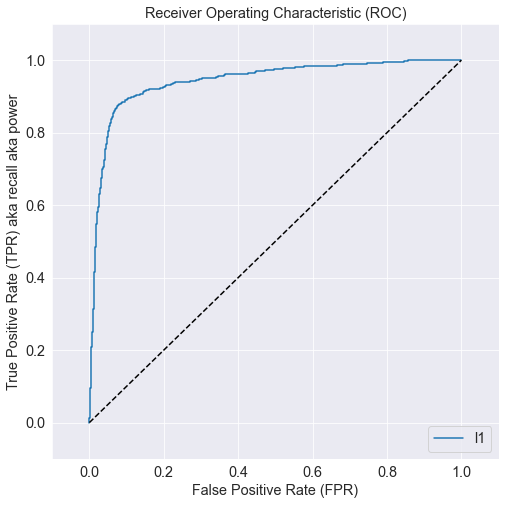



Results for: l2 

[[2014  127]
 [ 110  563]]

AUROC: 0.9423232675847548


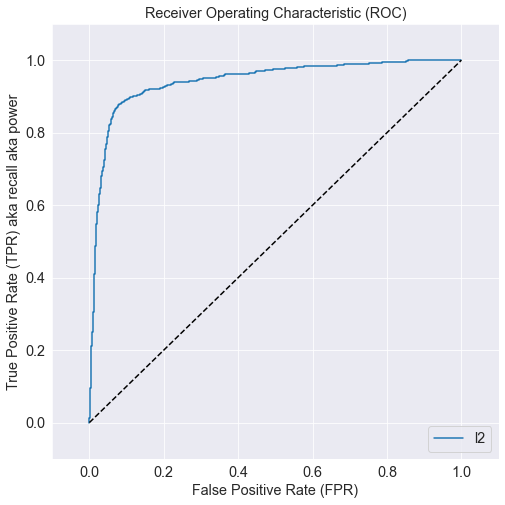



Results for: rf 

[[2127   14]
 [  50  623]]

AUROC: 0.9893472311962096


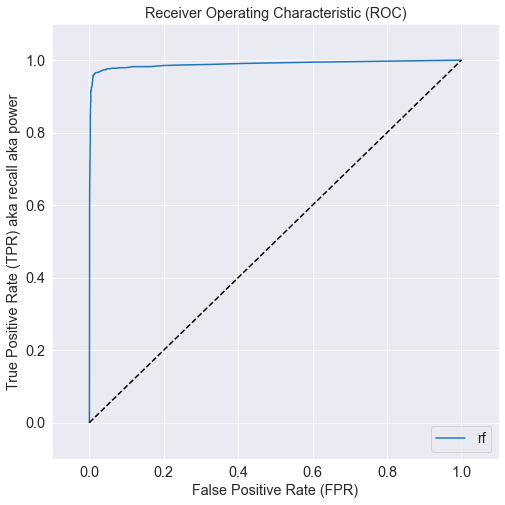



Results for: gb 

[[2120   21]
 [  46  627]]

AUROC: 0.989920486809222


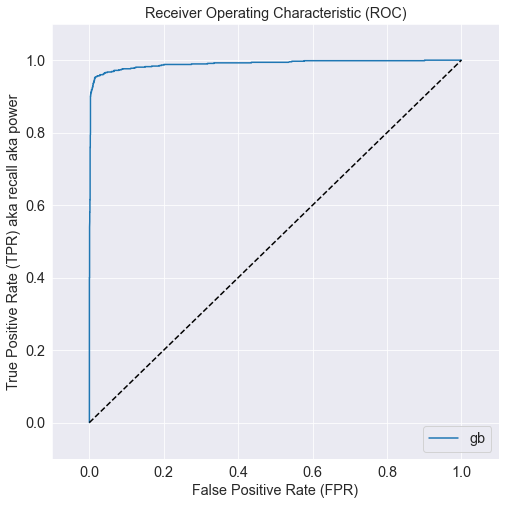

In [75]:
# confusion matrix, AUROC score and ROC curve

for name, model in fitted_models.items():
    print("Results for:", name, "\n")
    
    # get predictions and print confusion matrix
    pred = fitted_models[name].predict(X_test)
    print(confusion_matrix(y_test, pred))
    
    # get probabilities of predictions (positive class only) and display ROC curve
    pred = fitted_models[name].predict_proba(X_test)
    pred = [p[1] for p in pred]
    
    # print AUROC score
    print("\nAUROC:", roc_auc_score(y_test, pred))
    
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    fig = plt.figure(figsize=(8,8))
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.plot(fpr, tpr, label=name) # ROC curve
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'k--') # diagonal line
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.ylabel('True Positive Rate (TPR) aka recall aka power')
    plt.xlabel('False Positive Rate (FPR)')
    plt.savefig('Notebook Diagrams/diagram_ROC_{}.png'.format(name), bbox_inches='tight', format='png')
    plt.show()
    
    print("\n")

According to the updated results, the random forest and gradient-boosted trees models performed very well, with only a slight change in their AUROC scores after the inclusion of the new engineered features. The best score still came from the gradient-boosted trees model, but it was slightly lower than before, going from 99.19% to 99.16%. It's possible that the inclusion of the new features may have caused a small amount of overtraining or a slight increase in model complexity, resulting in a model that did not generalize as well as the simpler one.

Despite this, the scores are still very close, and both random forest models perform just as well as each other. Additionally, the inclusion of the new features led to a significant improvement in the performance of the logistic regression models, going from 85% to 94%. Overall, these results suggest that the new engineered features may be useful for improving the accuracy of the model, but further analysis may be required to determine the optimal balance between model complexity and performance.

## 6. Final Model Validation
To analyze the winning model, we will first reproduce the model from scratch using the existing .best_estimator scores. This will allow us to validate the winning scores and ensure that the model is working as expected.

In [76]:
# recreate the winning model as a sanity check
print(fitted_models['rf'].best_estimator_)

model = RandomForestClassifier(
    max_depth=None,
    max_features=0.33, 
    max_leaf_nodes=None, 
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0,
    n_estimators=200, 
    random_state=123)
model.fit(X_train, y_train)
print(model)

# validate AUROC
pred = model.predict_proba(X_test)
pred = [p[1] for p in pred]
print("\nAUROC:", roc_auc_score(y_test, pred))

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(max_features='sqrt',
                                        random_state=123))])
RandomForestClassifier(max_features=0.33, min_weight_fraction_leaf=0,
                       n_estimators=200, random_state=123)

AUROC: 0.9904899253449077


 ## A plot to showcase feature importance

## Plot 1


In [77]:
# take quick look at importances of features in order as they appear in analytical base table v2
coef = model.feature_importances_
coef

array([0.0970071 , 0.00385583, 0.06889817, 0.20095072, 0.000939  ,
       0.19849826, 0.1682827 , 0.00478039, 0.00471394, 0.00145583,
       0.00119999, 0.00061326, 0.00357654, 0.00135917, 0.0011179 ,
       0.00098131, 0.00028304, 0.00080773, 0.00303409, 0.00268267,
       0.00213942, 0.00290115, 0.00225461, 0.00530377, 0.01475648,
       0.02673012, 0.07177843, 0.02572414, 0.0160701 , 0.01828107,
       0.04902305])

In [78]:
# sort features according to importance and replace index with feature name
ind = np.argsort(-coef)
ind

array([ 3,  5,  6,  0, 26,  2, 30, 25, 27, 29, 28, 24, 23,  7,  8,  1, 12,
       18, 21, 19, 22, 20,  9, 13, 10, 14, 15,  4, 17, 11, 16],
      dtype=int64)

In [79]:
# check ranked scores
ranked_scores = [X.columns[ind[i]] for i in range(30)]
ranked_scores

['n_projects',
 'satisfaction',
 'tenure',
 'avg_monthly_hrs',
 'stars',
 'last_evaluation',
 'overworked',
 'overachiever',
 'slackers',
 'justajob',
 'workaholic',
 'unhappy',
 'underperformer',
 'salary_numeric',
 'last_evaluation_missing',
 'filed_complaint',
 'department_engineering',
 'department_sales',
 'salary_low',
 'department_support',
 'salary_medium',
 'salary_high',
 'department_IT',
 'department_finance',
 'department_Missing',
 'department_management',
 'department_marketing',
 'recently_promoted',
 'department_product',
 'department_admin']

In [81]:
# easier way
list(X.columns[ind][:30])


['n_projects',
 'satisfaction',
 'tenure',
 'avg_monthly_hrs',
 'stars',
 'last_evaluation',
 'overworked',
 'overachiever',
 'slackers',
 'justajob',
 'workaholic',
 'unhappy',
 'underperformer',
 'salary_numeric',
 'last_evaluation_missing',
 'filed_complaint',
 'department_engineering',
 'department_sales',
 'salary_low',
 'department_support',
 'salary_medium',
 'salary_high',
 'department_IT',
 'department_finance',
 'department_Missing',
 'department_management',
 'department_marketing',
 'recently_promoted',
 'department_product',
 'department_admin']

Ranking of feature importance:
1. n_projects (0.200951)
2. satisfaction (0.198498)
3. tenure (0.168283)
4. avg_monthly_hrs (0.097007)
5. stars (0.071778)
6. last_evaluation (0.068898)
7. overworked (0.049023)
8. overachiever (0.026730)
9. slackers (0.025724)
10. justajob (0.018281)
11. workaholic (0.016070)
12. unhappy (0.014756)
13. underperformer (0.005304)
14. salary_numeric (0.004780)
15. last_evaluation_missing (0.004714)
16. filed_complaint (0.003856)
17. department_engineering (0.003577)
18. department_sales (0.003034)
19. salary_low (0.002901)
20. department_support (0.002683)
21. salary_medium (0.002255)
22. salary_high (0.002139)
23. department_IT (0.001456)
24. department_finance (0.001359)
25. department_Missing (0.001200)
26. department_management (0.001118)
27. department_marketing (0.000981)
28. recently_promoted (0.000939)
29. department_product (0.000808)
30. department_admin (0.000613)


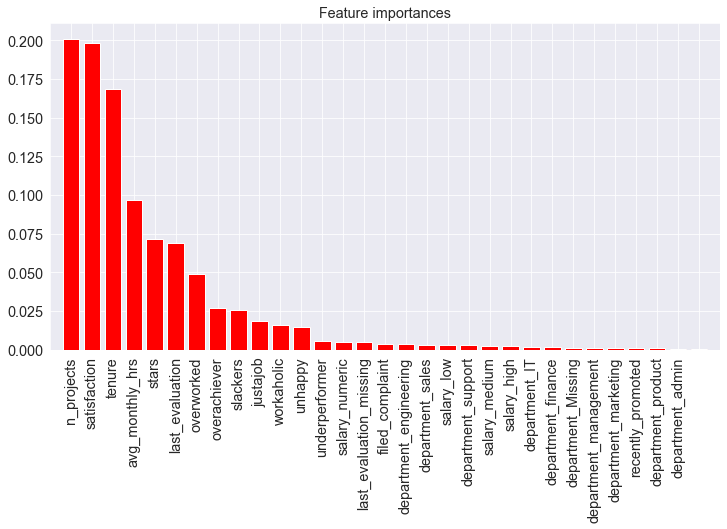

In [83]:
# Print list of feature importances and plot on a bar graph
print("Ranking of feature importance:")

for i in range(30):
    print("%d. %s (%f)" % (i + 1, X.columns[ind[i]], coef[ind[i]]))

plt.figure(figsize=(12,6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), coef[ind],
        color="r", align="center")
plt.xticks(range(X_train.shape[1]), ranked_scores, rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.savefig('Notebook Diagrams/diagram_feature_importance.png', bbox_inches='tight', format='png')
plt.show()

Based on the given comment, the top three most important features in the winning model were related to workload, happiness, and experience, respectively. This suggests that these factors have a significant impact on employee attrition.

Furthermore, two of the newly engineered features, "Stars" and "Overworked," were also found to be relatively strong predictors in the model, indicating that these features may be useful for predicting employee attrition. The "Stars" feature is related to high-performing employees, while the "Overworked" feature is related to employees who may be experiencing burnout due to excessive workload.

Overall, these findings provide valuable insights into the factors that contribute to employee attrition and suggest that incorporating additional features may improve the accuracy of the model.





In [84]:
## Saving the final model
with open('model_v2.pkl', 'wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)

## 7. Data processing functions for business

A function will be written for businesses that enables them to transform new data for the model, following the data pre-processing steps outlined in Section 2. This function will allow businesses to easily prepare new data for the model by applying the same transformations and feature engineering techniques used in the original dataset.

In [85]:
def clean_data(df):
    '''
    Data processing Step 1 - cleaning. Function drops employees out of business scope and duplicate entries, deals with missing values and data integrity issues, and performs one-hot encoding of categorical variables
    
    Arguments
    df - original dataframe
    
    Output 
    df - cleaned dataframe
    '''
    
    # remove out-of-scope temporary employees
    df = df[df.department != 'temp']
    
    # drop duplicate data
    df.drop_duplicates(inplace=True)
    
    # cleaning
    df.department.replace('information_technology', 'IT', inplace=True)
    
    # missing data in numerical features
    df.filed_complaint.fillna(0, inplace=True)
    df.recently_promoted.fillna(0, inplace=True)
    
    # missing data in categorical features
    df['department'].fillna('Missing', inplace=True)
    df['last_evaluation_missing'] = df.last_evaluation.isnull().astype(int)
    df.last_evaluation.fillna(0, inplace=True)

    # one-hot encoding of categorical variables
    df['status'] = pd.get_dummies(df.status).Left
    cleaned_df = pd.get_dummies(df, columns=['department', 'salary'])
    
    return cleaned_df

## Testing the cleaning process

In [87]:
# load the original dataset
df = pd.read_csv('employee_churn.csv')
analytical_base_table_v1_test = clean_data(df)
analytical_base_table_v1_test.reset_index(drop=True, inplace=True);

c:\users\msi\anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
c:\users\msi\anaconda3\envs\my_env\lib\site-packages\pandas\core\series.py:4515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
c:\users\msi\anaconda3\envs\my_env\lib\site-packages\pandas\core\series.py:4469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [88]:
# ABT from using cleaning_function
print(analytical_base_table_v1_test.shape)
display(analytical_base_table_v1_test.head(10))

(14068, 23)


,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,status,tenure,last_evaluation_missing,department_IT,department_Missing,department_admin,department_engineering,department_finance,department_management,department_marketing,department_procurement,department_product,department_sales,department_support,salary_high,salary_low,salary_medium
0,221,0.0,0.932868,4,0.0,0.829896,1,5.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,232,0.0,0.000000,3,0.0,0.834544,0,2.0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,184,0.0,0.788830,3,0.0,0.834988,0,3.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,206,0.0,0.575688,4,0.0,0.424764,0,2.0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,249,0.0,0.845217,3,0.0,0.779043,0,3.0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
5,140,0.0,0.589097,4,0.0,0.660020,0,4.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
6,121,1.0,0.625399,3,0.0,0.835571,0,3.0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
7,150,0.0,0.644586,4,0.0,0.796683,0,3.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
8,215,1.0,0.524114,3,0.0,0.715005,0,7.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
9,269,0.0,0.909364,5,0.0,0.994037,0,2.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [90]:
# Compare this with the ABT created in Section 2
analytical_base_table_v1 = pd.read_csv('Modelling table 1.csv')
analytical_base_table_v1.reset_index(drop=True, inplace=True);
print(analytical_base_table_v1.shape)
display(analytical_base_table_v1.head(10))

(14068, 24)


,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,status,tenure,salary_numeric,last_evaluation_missing,department_IT,department_Missing,department_admin,department_engineering,department_finance,department_management,department_marketing,department_procurement,department_product,department_sales,department_support,salary_high,salary_low,salary_medium
0,221,0.0,0.932868,4,0.0,0.829896,1,5.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,232,0.0,0.000000,3,0.0,0.834544,0,2.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,184,0.0,0.788830,3,0.0,0.834988,0,3.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,206,0.0,0.575688,4,0.0,0.424764,0,2.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,249,0.0,0.845217,3,0.0,0.779043,0,3.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
5,140,0.0,0.589097,4,0.0,0.660020,0,4.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
6,121,1.0,0.625399,3,0.0,0.835571,0,3.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
7,150,0.0,0.644586,4,0.0,0.796683,0,3.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
8,215,1.0,0.524114,3,0.0,0.715005,0,7.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
9,269,0.0,0.909364,5,0.0,0.994037,0,2.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


A function called "engineer_features" will be written for businesses that allows them to access the cleaned dataframe and engineer the features created in Section 5. This function will enable businesses to easily apply the same feature engineering techniques to new data, which can then be used to predict employee attrition using the winning model.

In [91]:
def engineer_features(df):
    '''
    Engineer new features derived from bivariate segmentation analysis in Section 2
    
    Arguments
    df - cleaned dataframe
    
    Output
    abt - final analytical base table
    '''
    
    # attach features to cleaned dataframe
    df['underperformer'] = ((df.last_evaluation < 0.6) & (df.last_evaluation_missing==0)).astype(int)
    df['unhappy'] = (df.satisfaction < 0.2).astype(int)
    df['overachiever'] = ((df.last_evaluation > 0.8) & (df.satisfaction > 0.7)).astype(int)
    df['stars'] = ((df.avg_monthly_hrs > 215) & (df.last_evaluation > 0.75)).astype(int)
    df['slackers'] = ((df.avg_monthly_hrs < 165) & (df.last_evaluation < 0.65) & (df.last_evaluation_missing==0)).astype(int)
    df['workaholic'] = ((df.avg_monthly_hrs > 210) & (df.satisfaction > 0.7)).astype(int)
    df['justajob'] = (df.avg_monthly_hrs < 170).astype(int)
    df['overworked'] = ((df.avg_monthly_hrs > 225) & (df.satisfaction < 0.2)).astype(int)
    abt = df
    
    #print distribution of new features
    print(df[['underperformer', 'unhappy', 'overachiever', 'stars', 'slackers', 'underperformer', 'unhappy', 'overachiever']].mean())
    
    return abt

## Testing those features

In [92]:
# engineer features using engineer_features function
analytical_base_table_v2_test = engineer_features(analytical_base_table_v1_test)

underperformer    0.285257
unhappy           0.092195
overachiever      0.177069
stars             0.241825
slackers          0.167686
underperformer    0.285257
unhappy           0.092195
overachiever      0.177069
dtype: float64


In [93]:
print(analytical_base_table_v2_test.shape)
display(analytical_base_table_v2_test.head())

(14068, 31)


,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,status,tenure,last_evaluation_missing,department_IT,department_Missing,department_admin,department_engineering,department_finance,department_management,department_marketing,department_procurement,department_product,department_sales,department_support,salary_high,salary_low,salary_medium,underperformer,unhappy,overachiever,stars,slackers,workaholic,justajob,overworked
0,221,0.0,0.932868,4,0.0,0.829896,1,5.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0
1,232,0.0,0.000000,3,0.0,0.834544,0,2.0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
2,184,0.0,0.788830,3,0.0,0.834988,0,3.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
3,206,0.0,0.575688,4,0.0,0.424764,0,2.0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0
4,249,0.0,0.845217,3,0.0,0.779043,0,3.0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0


In [94]:
# compare this to ABT created in Section 5
analytical_base_table_v2 = pd.read_csv('Modelling table 2.csv')
print(analytical_base_table_v2[['underperformer', 'unhappy', 'overachiever', 'stars', 'slackers', 'underperformer', 'unhappy', 'overachiever']].mean())
print("\n")
print(analytical_base_table_v2.shape)
display(analytical_base_table_v2.head())

underperformer    0.285257
unhappy           0.092195
overachiever      0.177069
stars             0.241825
slackers          0.167686
underperformer    0.285257
unhappy           0.092195
overachiever      0.177069
dtype: float64


(14068, 32)


,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,status,tenure,salary_numeric,last_evaluation_missing,department_IT,department_Missing,department_admin,department_engineering,department_finance,department_management,department_marketing,department_procurement,department_product,department_sales,department_support,salary_high,salary_low,salary_medium,underperformer,unhappy,overachiever,stars,slackers,workaholic,justajob,overworked
0,221,0.0,0.932868,4,0.0,0.829896,1,5.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0
1,232,0.0,0.000000,3,0.0,0.834544,0,2.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
2,184,0.0,0.788830,3,0.0,0.834988,0,3.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
3,206,0.0,0.575688,4,0.0,0.424764,0,2.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0
4,249,0.0,0.845217,3,0.0,0.779043,0,3.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0


# 8 . Conclusion

Our goal was to develop a binary classification model to predict employee turnover in a mid-sized company using a dataset of around 14,000 current and former employees obtained from elitedatascience.com in 2018. We identified several key factors related to employee turnover, including satisfaction, performance, workload, experience, department, and specific circumstances like recent promotions or filed complaints. We cleaned the dataset and created a set of 8 engineered features using clustering techniques, which allowed us to identify various employee "stereotypes" such as overworked and slackers. We trained the model using logistic regression, random forests, and gradient-boosted trees, and found that the best model was a random forest with an AUROC score of 99%, regardless of whether or not we included the engineered features. However, the logistic regression models performed substantially better on the dataset with the new features.
To further improve the model, we can engineer additional features that include tenure, which was found to be the third strongest predictor. These new features could relate to employee stereotypes based on experience level, such as "Unhappy veteran" for employees with long tenure and low satisfaction. While we don't expect these new features to improve the AUROC of the winning random forest, they may enhance the logistic regression performance. Another potential improvement is to create a set of functions to clean and engineer new data for the model, which would allow HR teams to use the model with ease. Currently, our scope is limited to delivering a trained .pkl file.